<img src="../images/titanic.jpg"  style="width: 350px" align="right";/>
A month ago, I finally joined Kaggle to get some practice applying machine learning algorithms. My first submission was to their [Titanic competition](https://www.kaggle.com/c/titanic). For the uninitiated, Kaggle is a website that hosts data science competitions, which are open to anyone, anywhere with an internet connection (with some [exceptions](https://www.kaggle.com/c/passenger-screening-algorithm-challenge/discussion/35118)). 

Generally, competitors are trying to write algorithms that best predict some kind of outcome. In the Titanic competition, for example, Kaggle provides data on 891 actual passengers aboard the Titanic. This includes information like name, social class, other family on board, and most importantly, whether or not each passenger survived. The goal is to use this 'training data' to build some kind of model or algorithm that correctly predicts each passenger's survival outcome. But the real test is whether your algorithm accurately predicts the survival outcomes for a set of passengers for whom you do not have survival information. This is called the 'test data', and your final accuracy score is calculated based on the number of correct predictions you make for this unlabeled data.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Set2", 10))

#from subprocess import check_output

# machine learning
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from scipy import interp
import re
from collections import OrderedDict
import fancyimpute

# Load training and test data and concatenate for pre-processing
data = pd.read_csv("./train.csv").assign(Training = 1)
testdata = pd.read_csv("./test.csv").assign(Survived = -99).assign(Training = 0)[list(data)]
data = pd.concat([data,testdata], ignore_index=True)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Training
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


A description of each of these variables can be found [here](https://www.kaggle.com/c/titanic/data).

## Feature Engineering and other Data Preprocessing

First, I constructed some new features/variables that may aid in predicting survival. 
 - From each passenger's name, I extracted their title (e.g., Mr., Ms.), their surname (and maiden name, if applicable)
 - From passengers' tickets, I extracted their deck
 - From passengers' number of siblings, parents, children, and spouses, I calculated an overall family size

In [2]:
# Title
re_title = re.compile(pattern = '(?<= )\w+\.')
data['Title'] = [re_title.search(name).group(0) for name in data.Name if re_title.search(name)]
# combining less frequent titles
data.loc[data.Title == 'Mme.', 'Title'] = 'Mrs.'
data.loc[data.Title == 'Ms.', 'Title'] = 'Miss.'
data.loc[data.Title == 'Mlle.', 'Title'] = 'Miss.'
military = ['Col.','Major.','Capt.']
Hon = ['Don.','Jonkheer.','Sir.', 'Lady.','Countess.','Dona.']
data.loc[[i in military for i in data.Title], 'Title'] = 'Mil.'
data.loc[[i in Hon for i in data.Title], 'Title'] = 'Hon.'
title_count = data.Title.value_counts()

# Last Name
re_lastname = re.compile(pattern = "[ a-zA-Z\\']+")
data['LastName'] = [re_lastname.search(name).group(0) for name in data.Name if re_lastname.search(name)]

# Maiden Name
re_maiden = re.compile(pattern = "\w+(?=\\))")
data['Maiden'] = [re_maiden.search(name).group(0) if re_maiden.search(name) else 'NA' for name in data.Name]
data['Maiden'].value_counts()

# Deck
re_cabin = re.compile(pattern = "[ABCDEFG]")
data.Cabin.fillna('Unknown', inplace=True)
data['Deck'] = [re_cabin.search(cabin[0]).group(0) if (cabin and re_cabin.search(cabin[0])) else cabin for cabin in data.Cabin]
data.loc[data.Deck=='T','Deck'] = 'Unknown'

### Visualizations
This is a good place to look at survival based on a few variables.

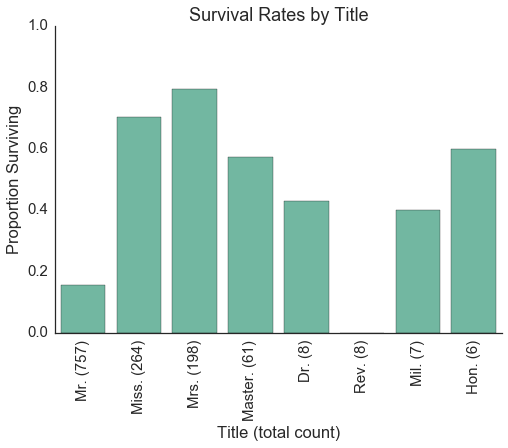

In [4]:
dataViz = data[data.Training == 1]

#  Viz: Survival ~ Title:
def ylab_survived(ax):
    ax.set_ylabel('Proportion Surviving')
labs = [title+' ('+str(count)+')'for title,count in zip(title_count.index, title_count)]
ax = sns.barplot(x = "Title", y = "Survived",data = dataViz, 
                 order=title_count.index, errwidth=0, color = sns.color_palette()[0]);
ax.set_xticklabels(labs, rotation = 90);
ylab_survived(ax)
ax.set_xlabel('Title (total count)')
ax.set_title('Survival Rates by Title')
sns.despine()
#ax.get_figure().savefig(dir+'survivalTitles2.png')

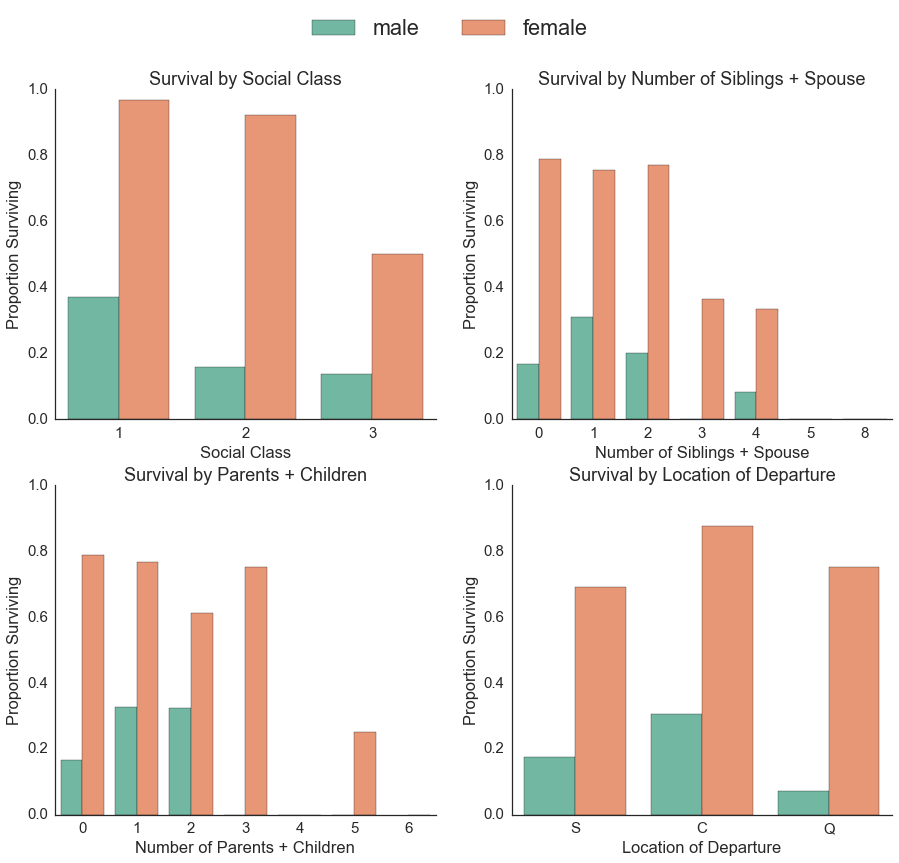

In [5]:
fig, axs = plt.subplots(2,2, figsize = (15,13))
sns.barplot(x = "Pclass", y = "Survived", hue = "Sex", data = dataViz, ax = axs[0,0], errwidth=0)
axs[0,0].set_title('Survival by Social Class')
axs[0,0].set_xlabel('Social Class')
sns.barplot(x = "SibSp", y = "Survived", hue = "Sex",data = dataViz, ax = axs[0,1], errwidth=0)
axs[0,1].set_title('Survival by Number of Siblings + Spouse')
axs[0,1].set_xlabel('Number of Siblings + Spouse')
sns.barplot(x = "Parch", y = "Survived", hue = "Sex",data = dataViz, ax = axs[1,0], errwidth=0)
axs[1,0].set_title('Survival by Parents + Children')
axs[1,0].set_xlabel('Number of Parents + Children')
sns.barplot(x = "Embarked", y = "Survived", hue = "Sex",data = dataViz, ax = axs[1,1], errwidth=0)
axs[1,1].set_title('Survival by Location of Departure')
axs[1,1].set_xlabel('Location of Departure')

# common legends
for ax in axs.flatten():
    ax.legend_.remove()
    ylab_survived(ax)
fig.subplots_adjust(top=0.9)
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=2, fontsize = 'large')

sns.despine()

In [6]:
# Binning Age For Viz:
b = np.arange(0, 81, 5) # bins
agelabels = [str(v+1)+'-'+str(b[i+1]) for i,v in enumerate(b[:-1])] # labels
dataViz['Age2'] = pd.cut(data['Age'], bins=b, labels= agelabels)
dataViz.loc[:,'Age2'] = dataViz.Age2.cat.reorder_categories(agelabels, ordered=True)

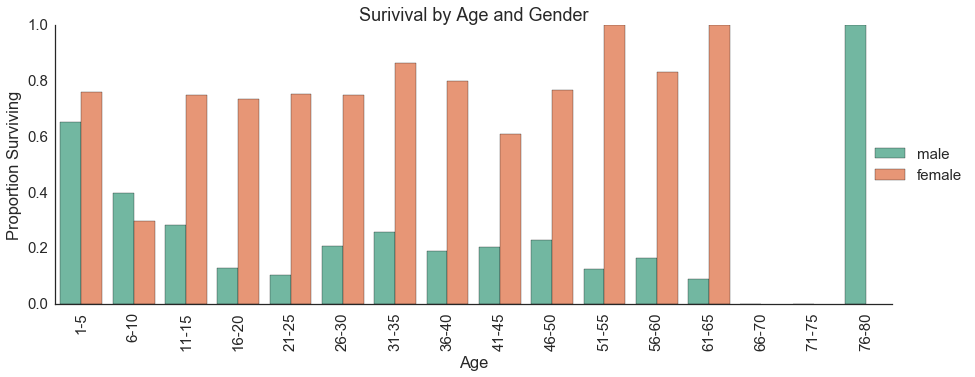

In [7]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(x = 'Age2', y = 'Survived', hue = 'Sex', data=dataViz, ax = ax, errwidth=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set_xlabel('Age')
ax.legend(loc = 'center right', bbox_to_anchor = (1.1, .5))
ax.set_title('Surivival by Age and Gender')
ylab_survived(ax)
sns.despine()

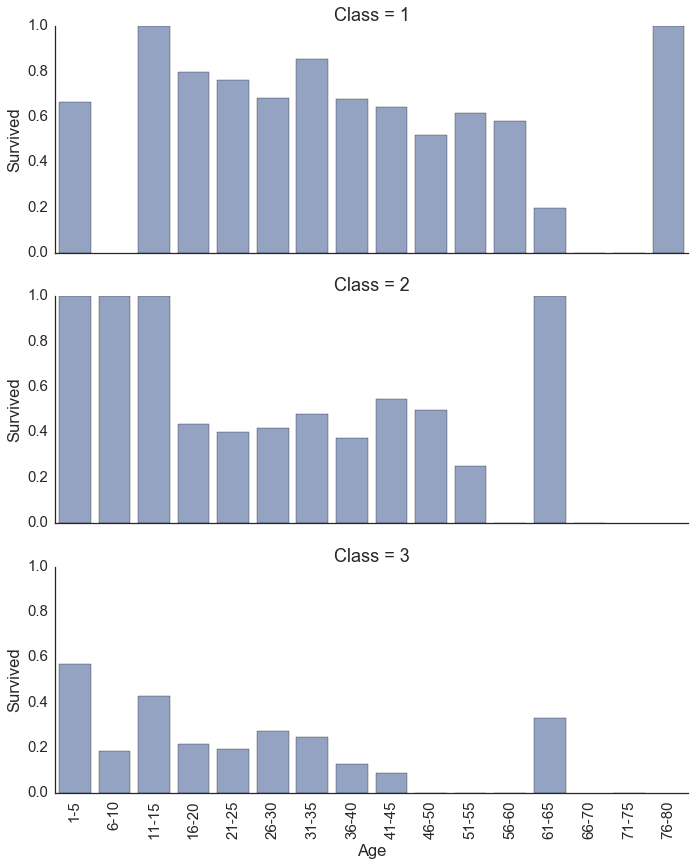

In [8]:
g = sns.factorplot(x = 'Age2', y = 'Survived', data = dataViz, row = 'Pclass', kind = 'bar', 
                   aspect=2.5, errwidth = 0, color = sns.color_palette()[2])
g.set_xticklabels(rotation = 90);
g.axes.flatten()[0].set_title('Class = 1');
g.axes.flatten()[1].set_title('Class = 2');
g.axes.flatten()[2].set_title('Class = 3');
g.axes.flatten()[2].set_xlabel('Age');


Overall, these plots indicate that while age, class, and gender may not independently contribute to whether or not someone survived. For instance, age may have a stronger effect on survival in 3rd class than in 1st. And age has different effects for men and women. Random forests typically can account of these interaction effects without their explicit inclusion in the matrix of features, but we'll go ahead and calculate them ourselves anyway.

### Dummy / One-hot encoding
In R this is unnecessary, but in scikit-learn, it is still necessary to dummy code nominal variables.

In [9]:
# Dummy coding
data[['Title', 'LastName', 'Maiden','Pclass','Sex','Deck']].isnull().sum() # no NAs
data = pd.get_dummies(data, columns=['Title', 'Pclass','Sex','Deck','Embarked'])

### Imputing data
Age is an important variable for understanding chance of survival, but many passengers' ages are missing. To solve this issue I used an algorithm called MICE to impute reasonable estimates for these missing ages.

In [10]:
%%capture

# Droping unneeded variables -- including survival
outcomes = data.Survived
Training = data['Training']
data.drop(['PassengerId','Survived','Name','SibSp','Parch','Ticket','Fare',
            'Training','Cabin','Maiden','LastName'], axis = 1, inplace=True)

# Imputing Age
def impute(df):
    return pd.DataFrame(fancyimpute.MICE().complete(np.array(df)), columns = list(df))
data_full = impute(data).join(Training)

### Cacluating variable interactions from dummy variables

In [11]:
def dummyinteractions(df, varstems):
    df = df.copy()
    namesdict = getnames(varstems, list(df))
    for i, stem1 in enumerate(varstems[:-1]):
        for stem2 in varstems[i+1:]:
            df = multiply(df, namesdict[stem1], namesdict[stem2])
    return df

def multiply(df, list1, list2):
   for var1 in list1:
       for var2 in list2:
           newname = var1+'_'+var2
           df[newname] = df[var1]*df[var2]
   return df

def getnames(stems, varlist):
    d = {}
    for stem in stems:
        d[stem] = [var for var in varlist if var.startswith(stem)]
    return d

interactionvars = ['Pclass','Sex','FamilySize', 'Age']
data_full = dummyinteractions(data_full, interactionvars)

### Creating cross validation data

In [12]:
# Remove test/submission data
submissiondat = data_full[data_full.Training == 0].drop(['Training'], axis = 1)
data_full = data_full[data_full.Training == 1].drop(['Training'], axis = 1)
outcomes = outcomes[outcomes != -99]

# Split training data into cross-validation sets
X_train, X_test, y_train, y_test = train_test_split(
            data_full, outcomes, test_size = 0.1, random_state = 50)

# Training a Random Forest
In my submission, I used an algorithm called Random Forest to generate predictions. A random forests is an iterative process. At each iteration a unique 'Decision Tree' is created. A single decision tree is basically just a sequential set of rules for how to categorize someone. For instance, a tree might specify that if a passenger is Female, under age 14, and in 3rd class, then we will guess that she survives. A single decision tree is prone to 'overfitting'; that is, it can get too specific to the data that we used to train it. So, it may be able to correctly classify 100% of people in your training data (i.e., people for whom you know their survival outcome), but it may not predict the outcomes of a different set of people very well (i.e., people in my test data). To combat this problem, random forests calculate many decision trees (often hundreds), and averages them together. Random forests also inject other little bits of randomness during training. Overall, this allows your random forest algorithm to generalize, or provide better predictions for new data.

### Visualizing Effects of Hyperparameters on Accuracy
There are a number of 'hyperparameters' that control the how the algorithm is built, and subseqently how it performs. The following code, which is not my own, illustrates the effect of 2 hyperparameters on accuracy: number of decision trees in the forest, and number of variables to choose from to create 'branches' (or nodes) on each tree. I did not save the source URL for the code, so I can't cite it here. But I will update it as soon as I can find it.

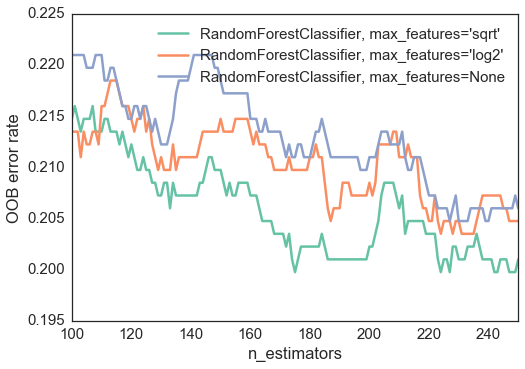

In [13]:
RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = X_train, y_train

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

The plot suggests that the error rate settles after about 230 trees, and that using a square-root or log2 constraint on available variables are equivalent. Since there are other hyperparameters that could influence the algorithm, below I use scikit-learn's GridSearchCV module to select the best hyperparameters.

In [14]:
# GridSearchCV to optimize hyperparameters

rfcGS = RandomForestClassifier(random_state=1)
gridparams = {'n_estimators':[220, 240, 260],
                'min_samples_split': [2, 3, 6],
                'min_samples_leaf': [1, 3, 5],
                'max_features': ['auto','log2']} 

clf = GridSearchCV(rfcGS, gridparams, cv = 5)
clf.fit(X_train, y_train)

print '\nOptimized parameters: '
for k in clf.best_params_:
    print k + ': ' + str(clf.best_params_[k])

print 'CV Hold-out data accuracy: {:.2f}%'.format(clf.score(X_test, y_test)*100) # Hold out score comparatively low -- overfitting


Optimized parameters: 
max_features: auto
min_samples_split: 2
n_estimators: 240
min_samples_leaf: 3
CV Hold-out data accuracy: 76.67%


## Results
Based on my cross-validation accuracy, I could expect about 77% accuracy on new data. And that's just about what happened. My predictions were 79.4% accurate, and this placed me (currently) 1691 out of >7000.  So -- not AMAZING, but in the top ~25%, which I'm happy with for my first data science competition.

If I wanted, I could do a little more feature engineering and try some different algorithms to see if I can do any better. I think people are getting the highest accuracy out of ensemble methods. But this will do for now.